<a href="https://colab.research.google.com/github/mahdishirvani79/Content-aware-image-retargeting/blob/main/content_Aware_Image_Retargeting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Improved Seam Carving based of ResNet**<br>
In this article we are going to present a novel seam carving method, that preserves edges of each object.<br>
The method uses ResNet as a model for semantic segmentation, that can be interpreted as objects.<br>
At the end my results on test images will be shown.



A CAIR process consists of two parts. One is exraction of importance map, and the other is a scaling method. 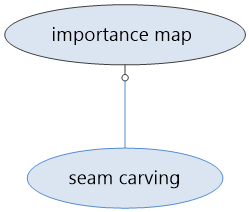<br>We suggest to put a new step in between of these steps. this step uses semantic segmentation, and object detection to enhance the importance map, and adapt it for retargeting intentions.

We are going to use some repositories, presented by others. These repositories is going to be restored in google drive. if You want, change pathes in your google drive accordingly. Then we are going to download ResNet repository from github.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


As presented in [this notebook](https://colab.research.google.com/github/CSAILVision/semantic-segmentation-pytorch/blob/master/notebooks/DemoSegmenter.ipynb) for semantic segmentation using pretrained ResNet, we have to download the weights and biases, build a model and set the weights and biases using downloaded information. Notice that base idea for ResNet parts are taken from above notebook.<br> The bash code in the cell below should run only once.
The base code for Seam Carving functions is in this [github repository.](https://github.com/andrewdcampbell/seam-carving/)

In [ ]:
%%bash
pip install yacs 
git clone https://github.com/CSAILVision/semantic-segmentation-pytorch.git '/content/drive/MyDrive/cv_project/modules/Resnet'
sudo chmod 777 /content/drive/MyDrive/cv_project/modules/Resnet/demo_test.sh 
DOWNLOAD_ONLY=1 /content/drive/MyDrive/cv_project/modules/Resnet/demo_test.sh 

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/cv_project/modules/Resnet')

In [ ]:
import cv2
import torch
from google.colab.patches import cv2_imshow
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import math
from numba import jit, njit
from scipy import ndimage as ndi
import os
import csv 
import scipy.io
import torchvision.transforms
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode
import warnings
warnings.filterwarnings('ignore')

Here we create a CNN based on ResNet architecture and set the weights and biases based on pretrained model. You need to have CUDA installed on your system to be able to run the code below.



In [ ]:
colors = scipy.io.loadmat('/content/drive/MyDrive/cv_project/modules/Resnet/data/color150.mat')['colors']
names = {}
with open('/content/drive/MyDrive/cv_project/modules/Resnet/data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]


# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='/content/drive/MyDrive/cv_project/modules/Resnet_data/ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='/content/drive/MyDrive/cv_project/modules/Resnet_data/ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Functions implemented below are meant for image semantic segmentation and visualizing it. The function predict_image uses segmentation_module presented above as the model to predict image with.

In [ ]:
import numpy
def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = np.concatenate((img, pred_color), axis=1)
    display(Image.fromarray(im_vis))


def predict_image(img_original):
  global segmentation_module
  # Load and normalize one image as a singleton tensor batch
  pil_to_tensor = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
          std=[0.229, 0.224, 0.225])  # across a large photo dataset.
  ])
  img = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
  pil_image = Image.fromarray(img).convert("RGB")
  # img_original = np.array(pil_image)
  img_data = pil_to_tensor(pil_image)
  singleton_batch = {'img_data': img_data[None].cuda()}
  output_size = img_data.shape[1:]
  with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
  # Get the predicted scores for each pixel
  _, pred = torch.max(scores, dim=1)
  pred = pred.cpu()[0].numpy()
  return pred

The image we work on is Diane image, one of the most challenging images in computer vision.

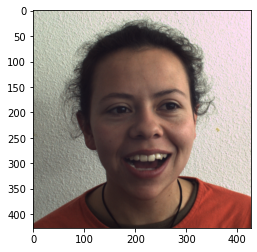

In [ ]:
img_original = cv2.imread('/content/drive/MyDrive/cv_project/test_images/Diana.png')
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))

We now run the semantic segmentation code below to find diffrent parts of the image. every color represents an image part

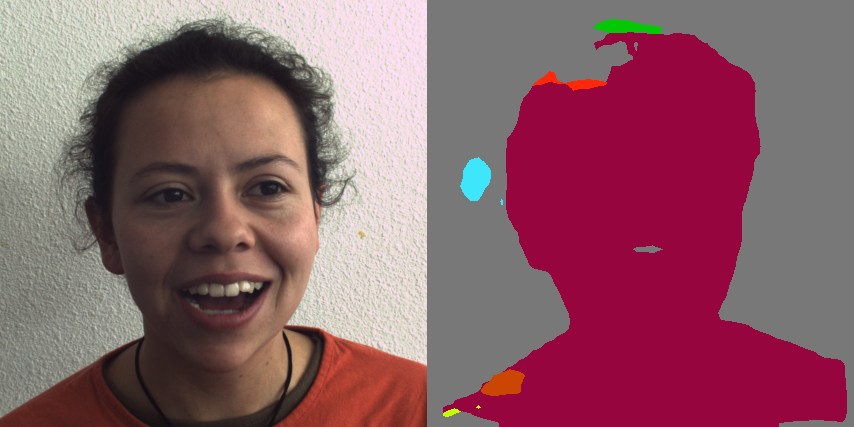

In [ ]:
pred_image = predict_image(img_original)
visualize_result(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB), pred_image)

ResNet also has this ability to detect objects in the image. below is name of every object detected. The topest name is the most occured object. meaning the topper name of object, the more pixels it has.

In [ ]:
objects_size = np.unique(pred_image).size
predicted_classes = np.bincount(pred_image.flatten()).argsort()[::-1]
image_names = [names[c+1] for c in predicted_classes[: min(objects_size, 15)]]
print(image_names)

['person', 'wall', 'water', 'chair', 'tree', 'rock', 'bench']


Seam Carving algorithm uses an importancen map to define most important pixels in an image. There are many ways to define importance map, e.g., gradient and saliency information. For illustration puposes, we use gradient map as importance map now. The name backward energy is the name used for gradient map is seam carving literature. we will come back to this topic shortly.

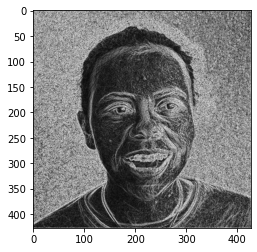

In [ ]:
def get_backward_energy(im):
    """
    Simple gradient magnitude energy map.
    """
    xgrad = ndi.convolve1d(im, np.array([1, 0, -1]), axis=1, mode='wrap')
    ygrad = ndi.convolve1d(im, np.array([1, 0, -1]), axis=0, mode='wrap')

    grad_mag = np.sqrt(np.sum(xgrad**2, axis=2) + np.sum(ygrad**2, axis=2))

    return grad_mag

gradient_map = get_backward_energy(img_original)
plt.imshow(gradient_map, cmap='gray')

 But the problem is that these methods are not aware of objects. we are going to introduce a method to consider object information. in this method we consider we already have an importance map. Better methods to initiate importance map will be dissgussed later. Considering we have the importance map, next stage is to normalize all information of importace map over an object. Some objects might be large (like sky) and have a lot of importance amounts in them, while they are not importante. Some object like (human face) might be importante but dont have much importance information.<br>
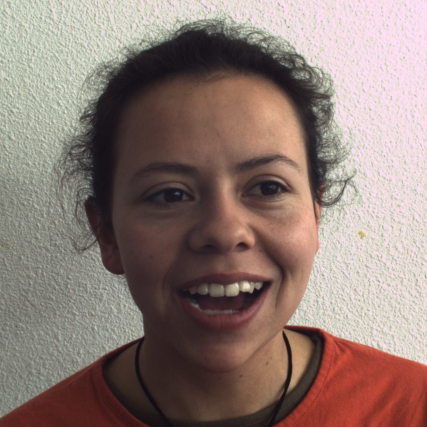
<br>So if we normalize importance information on all of the object, objects with mistakenly high importance will have low values on importance map.<br>Another thing that we can do, knowing objects, is predifining some more important objects, like human, and double their base importance.

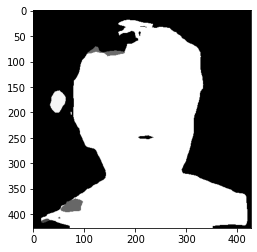

In [ ]:
def get_base_importance_map(pred_image, importance_map): 
  important_objects = ['person']
  out_map = np.zeros(pred_image.shape)
  objects_size = np.unique(pred_image).size
  predicted_classes = np.bincount(pred_image.flatten()).argsort()[::-1]
  for c in predicted_classes[:objects_size]:
    pred_mask = pred_image.copy()
    pred_mask[pred_mask != c] = 0
    pred_mask[pred_mask == c] = 1
    importance_map_filtered= np.multiply(importance_map, pred_mask)
    s = np.sum(np.sum(importance_map_filtered)) / np.sum(np.sum(pred_mask))
    if names[c+1] in important_objects:
      s = s * 2
    out_img = np.full(pred_mask.shape, s)
    filtered = np.multiply(out_img, pred_mask)
    out_map = np.add(out_map,filtered)
  return out_map

importance_map = gradient_map
base_importance_map = get_base_importance_map(pred_image, importance_map)
plt.imshow(base_importance_map, cmap='gray')

As you can see the important objects, have higher base value in importance map. Now we can add the gradient information to be able to use edges inside an object.

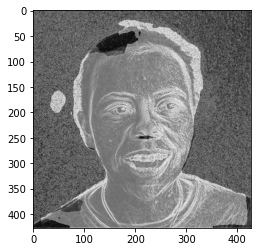

In [ ]:
importance_map = base_importance_map + gradient_map 
plt.imshow(importance_map, cmap='gray')

Forward energy, A better way to define importance map is defined in [this article](https://d1wqtxts1xzle7.cloudfront.net/40271738/Improved_seam_carving_for_video_retarget20151122-13635-7w8z8h-with-cover-page-v2.pdf?Expires=1657356020&Signature=PDs9rM0OHzv0rO1o2O4w3Ky9RQ47igACL97Ku~SO4QqngTd~WYxW7ErXrzNzcDkg9EURi61GmB4qUGTEom9wXZJamh9C5okyuPY2XroG-vxKaTo2yjTBPVlMQXC4hylEKo-bWumbiLZYU4kvNvTvkSGCHY-RYEF1qFy2MNeTSm23RZK7pfpKe~Cr4i2K5IzuqSfY6~yWj3Rc1hyMQApNpuIMbaDae2SyKkfwilrYKCm3izjge5xSQY5o0sTxJ8nSx5POqj8TR-lHw7p2U01bNH1tmsFvd6x3yxhFlTsijPT1VUepwcFTEfZEinSG2-woIg4bmkwmvfhfkfgvKjcxeA__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA). The main idea is to calculate importance through the energy that will be injected to the image, after seam removal. 

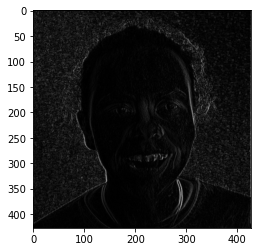

In [ ]:
@jit
def get_forward_energy(im):
    """
    Forward energy algorithm as described in "Improved Seam Carving for Video Retargeting"
    by Rubinstein, Shamir, Avidan.
    Vectorized code adapted from
    https://github.com/axu2/improved-seam-carving.
    """
    h, w = im.shape[:2]
    im = cv2.cvtColor(im.astype(np.uint8),
                      cv2.COLOR_BGR2GRAY).astype(np.float64)

    energy = np.zeros((h, w))
    m = np.zeros((h, w))

    U = np.roll(im, 1, axis=0)
    L = np.roll(im, 1, axis=1)
    R = np.roll(im, -1, axis=1)

    cU = np.abs(R - L)
    cL = np.abs(U - L) + cU
    cR = np.abs(U - R) + cU

    for i in range(1, h):
        mU = m[i-1]
        mL = np.roll(mU, 1)
        mR = np.roll(mU, -1)

        mULR = np.array([mU, mL, mR])
        cULR = np.array([cU[i], cL[i], cR[i]])
        mULR += cULR

        argmins = np.argmin(mULR, axis=0)
        m[i] = np.choose(argmins, mULR)
        energy[i] = np.choose(argmins, cULR)

    return energy

forward_energy = get_forward_energy(img_original)
plt.imshow(forward_energy, cmap='gray')

Saliency information is measurement to find important pixels of image based on human vision system (HVS). fortunately saliency detection is implemented in opencv.

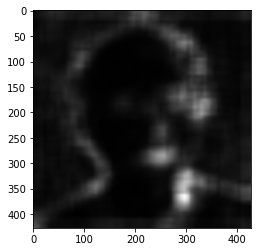

In [ ]:
def get_saliency(img):
  img = img.astype('float32')
  saliencyobj = cv2.saliency.StaticSaliencySpectralResidual_create()
  (success, saliencyMap) = saliencyobj.computeSaliency(img)
  saliency = (saliencyMap * 255).astype("uint8")
  return saliency

saliency = get_saliency(img_original)
plt.imshow(saliency, cmap='gray')

We add the forward energy with saliency information. And use this as our feed to base importance map algorithm. Finally by adding forward energy and saliency to base importance map, to use gradients inside an object, we have our importance map to go to next level.

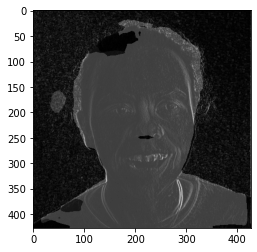

In [ ]:
def get_importance_map(im, objects_mask):
    forward_energy = get_forward_energy(im)
    saliency = get_saliency(im)
    importance_map = forward_energy + saliency
    base_importance_map = get_base_importance_map(objects_mask, importance_map)
    importance_map = base_importance_map + forward_energy
    return importance_map


importance_map = get_importance_map(img_original, pred_image)
plt.imshow(importance_map, cmap='gray')

Next stage is the seam carving algorithm. As I said before, The base code is taken from [this repository](https://github.com/andrewdcampbell/seam-carving/). These functions are implemented in the repository and doesn't need any change.

In [ ]:

SEAM_COLOR = np.array([255, 200, 200])    # seam visualization color (BGR)


@jit
def visualize(im, boolmask=None, rotate=False):
    vis = im.astype(np.uint8)
    if boolmask is not None:
        vis[np.where(boolmask == False)] = SEAM_COLOR
    if rotate:
        vis = rotate_image(vis, False)
    cv2.imshow("vis", vis)
    cv2.waitKey(1)
    return vis


@jit
def resize(image, width):
    dim = None
    h, w = image.shape[:2]
    dim = (width, int(h * width / float(w)))
    return cv2.resize(image, dim)


@jit
def rotate_image(image, clockwise):
    k = 1 if clockwise else 3
    return np.rot90(image, k)


@jit
def remove_seam(im, boolmask):
    h, w = im.shape[:2]
    boolmask3c = np.stack([boolmask] * 3, axis=2)
#   plt.imshow(im)
#   plt.imshow(boolmask3c)
    a = im[boolmask3c].reshape((h, w - 1, 3))
#   plt.imshow(a)
    return a


@jit
def remove_seam_grayscale(im, boolmask):
    h, w = im.shape[:2]
    return im[boolmask].reshape((h, w - 1))



In [ ]:
@jit
def get_minimum_seam(im, objects_mask):
    """
    DP algorithm for finding the seam of minimum energy. Code adapted from 
    https://karthikkaranth.me/blog/implementing-seam-carving-with-python/
    """
    h, w = im.shape[:2]
    M = get_importance_map(im, objects_mask)
    backtrack = np.zeros_like(M, dtype=np.int)

    # populate DP matrix
    for i in range(1, h):
        for j in range(0, w):
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i-1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    # backtrack to find path
    seam_idx = []
    boolmask = np.ones((h, w), dtype=np.bool)
    j = np.argmin(M[-1])
    for i in range(h-1, -1, -1):
        boolmask[i, j] = False
        seam_idx.append(j)
        j = backtrack[i, j]

    a = boolmask.astype(dtype=np.uint8) * 255
    seam_idx.reverse()
    return np.array(seam_idx), boolmask


def seams_removal(im, num_remove, objects_mask, vis=False, rot=False):
    for _ in range(num_remove):
        seam_idx, boolmask = get_minimum_seam(im, objects_mask)
        if vis:
            visualize(im, boolmask, rotate=rot)
        im = remove_seam(im, boolmask)
        objects_mask = remove_seam_grayscale(objects_mask, boolmask)
        # print(111111111111111111)
    return im


def seam_carve(im, dy, dx, objects_mask, vis=False):
    im = im.astype(np.float64)
    h, w = im.shape[:2]
    assert h + dy > 0 and w + dx > 0 and dy <= h and dx <= w

    output = im

    if dx > 0:
        output = seams_removal(output, dx, objects_mask, vis)

    if dy > 0:
        output = rotate_image(output, True)
        objects_mask = rotate_image(objects_mask, True)
        output, objects_mask = seams_removal(
            output, dy, objects_mask, vis, rot=True)
        output = rotate_image(output, False)
    return output


Finally, we pack everything together.

In [ ]:
def Image_retarget(im, x_per, y_per, vis_objects=False):
  dx = int(im.shape[0] * (1 - x_per))
  dy = int(im.shape[1] * (1 - y_per))
  pred_image = predict_image(img_original)
  if vis_objects:
    visualize_result(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), pred_image)
  out = seam_carve(im, dy=dy, dx=dx, objects_mask=pred_image, vis=False)
  return out

We run the upper operation on test images:

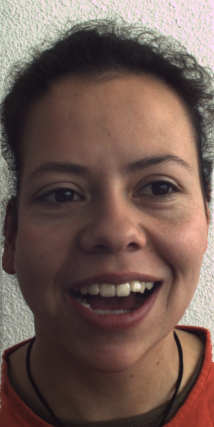

In [ ]:
img_original = cv2.imread('/content/drive/MyDrive/cv_project/test_images/Diana.png') 
out = Image_retarget(img_original, x_per=0.5, y_per=1, vis_objects=False)
cv2_imshow(out)
# cv2.imwrite('/content/drive/MyDrive/cv_project/test_images/Diana_ret.png', out)

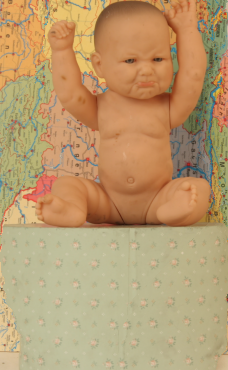

In [ ]:
img_original = cv2.imread('/content/drive/MyDrive/cv_project/test_images/Baby.png') 
out = Image_retarget(img_original, x_per=0.5, y_per=1, vis_objects=False)
cv2_imshow(out)
# cv2.imwrite('/content/drive/MyDrive/cv_project/test_images/Baby_ret.png', out)

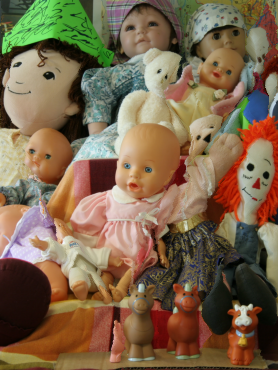

In [ ]:
img_original = cv2.imread('/content/drive/MyDrive/cv_project/test_images/Dolls.png') 
out = Image_retarget(img_original, x_per=0.5, y_per=1, vis_objects=False)
cv2_imshow(out)
# cv2.imwrite('/content/drive/MyDrive/cv_project/test_images/Dolls_ret.png', out)

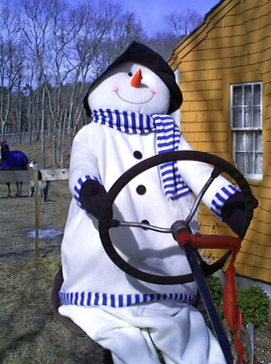

In [ ]:
img_original = cv2.imread('/content/drive/MyDrive/cv_project/test_images/Snowman.png') 
out = Image_retarget(img_original, x_per=0.5, y_per=1, vis_objects=False)
cv2_imshow(out)
# cv2.imwrite('/content/drive/MyDrive/cv_project/test_images/Snowman_ret.png', out)

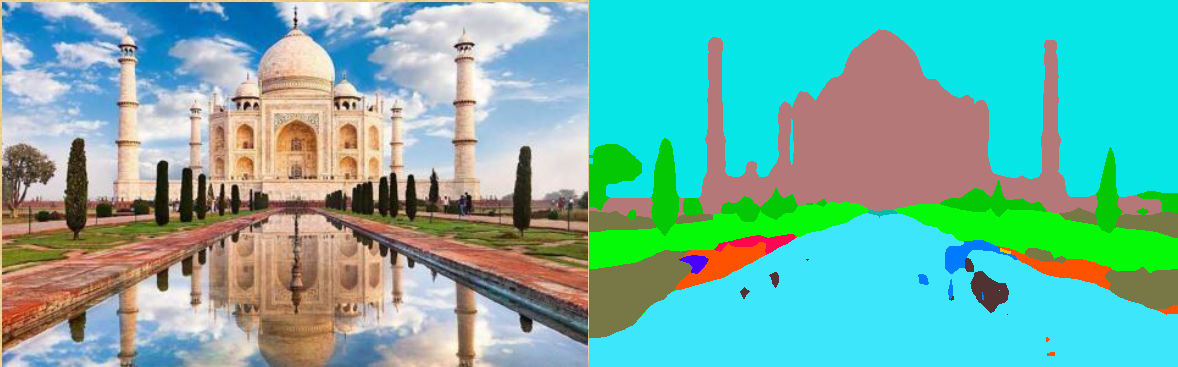

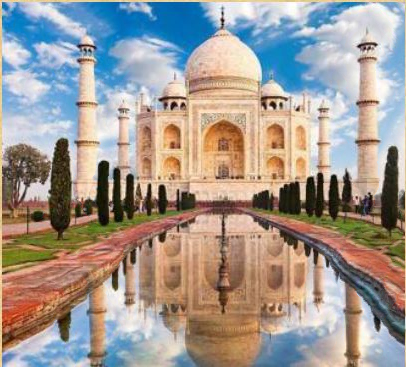

In [ ]:
img_original = cv2.imread('/content/drive/MyDrive/cv_project/test_images/test6.JPG') 
out = Image_retarget(img_original, x_per=0.5, y_per=1, vis_objects=True)
cv2_imshow(out)

As we can see the presented method can have a large impact on retargeted image quality, compared to the base seam carving method. The bottleneck of this method is object detection part. if an object is not detected truely, or a part of an object is detected out of the object, it has a lot of bad impact on output image. Like Diana image.